- **Author:** [Dace Apšvalka](https://www.mrc-cbu.cam.ac.uk/people/dace.apsvalka/) with very minor edits by [Rik Henson](https://www.mrc-cbu.cam.ac.uk/people/rik.henson/)
- **Date:** November 2024  
- **conda environment**: This uses the [mri environment](https://github.com/RikHenson/PythonNeuroimagingCourse/blob/main/mri_environment.yml)

# MRI Data Manipulation With NiBabel and Nilearn

In neuroimaging research, the ability to efficiently load, inspect, and manipulate MRI data is essential for both exploration and analysis. Python libraries such as [NiBabel](http://nipy.org/nibabel/) and [Nilearn](https://nilearn.github.io/stable/index.html) provide powerful tools for handling neuroimaging data in common formats like NIfTI. In this tutorial, we will explore how to use these libraries to perform fundamental operations on MRI data, including loading images, inspecting headers, working with affine transformations, and manipulating the data itself.

----------

**Table of contents**
1. Import required packages and set up the some stuff   
2. Loading and inspecting images with NiBabel    
2.1. Header  
2.2. Data   
2.3. Affine   
1. Image manipulation with NiLearn   
3.1. The mean image   
3.2. Resample image to a template    
3.3. Smooth an image   
3.4. Plotting a time course    
3.5. Masking an image


-------

## Import required packages and set up the some stuff

In [2]:
import os
import nibabel
import nilearn

from bids.layout import BIDSLayout

import matplotlib.pyplot as plt
#import pylab as plt

import numpy 
# Set numpy to print 3 decimal points and suppress small values
numpy.set_printoptions(precision=3, suppress=True)

# to show plots in cell
%matplotlib inline   

Throughout the examples, we will work with one subject's anatomical and functional images, which we will retrieve from our BIDS dataset.

In [3]:
wd = '/mnt/c/Users/rh01/PythonNeuroimagingCourse/FaceRecognition/' # <-- CHANGE TO YOURS
#wd = 'C:\\Users\\rh01\\PythonNeuroimagingCourse\\FaceRecognition'
os.chdir(wd)
print(f"Working directory currently {os.getcwd()}")

fmri_data_dir = os.path.join(wd,'data')

# Initialize the BIDS layout
layout = BIDSLayout(fmri_data_dir)

# Get subject's T1w image and all Bold images
anat_file = layout.get(subject='15', extension='nii.gz', datatype='anat', return_type='filename')[0]
bold_file = layout.get(subject='15', extension='nii.gz', suffix='bold', return_type='filename')[0]

# Print the file names
print("Subject's anatomical image", anat_file)
print("Subject's functional image", bold_file)

Working directory currently /mnt/c/Users/rh01/PythonNeuroimagingCourse/FaceRecognition
Subject's anatomical image /mnt/c/Users/rh01/PythonNeuroimagingCourse/FaceRecognition/data/sub-15/ses-mri/anat/sub-15_ses-mri_acq-mprage_T1w.nii.gz
Subject's functional image /mnt/c/Users/rh01/PythonNeuroimagingCourse/FaceRecognition/data/sub-15/ses-mri/func/sub-15_ses-mri_task-facerecognition_run-01_bold.nii.gz


## Loading and inspecting images with NiBabel

First, let's use the `load()` function to create a `NiBabel` image object from a NIfTI file. 

In [4]:
anat_image = nibabel.load(anat_file)
bold_image = nibabel.load(bold_file)

# Print the shape of both images
print(f"The shape of the anatomical image: {anat_image.shape}")
print(f"The shape of the functional image: {bold_image.shape}")

The shape of the anatomical image: (256, 256, 192)
The shape of the functional image: (64, 64, 33, 208)


Loading a NIfTI file with NiBabel provides us with a special type of data object that encapsulates all the information stored in the file. In Python, each piece of this information is referred to as an attribute. To explore all available attributes, type `anat_image.` followed by pressing `Tab`. Here, we’ll focus on three key attributes:
- Header
- Data
- Affine

### Header

Header contains important metadata about the image, including information such as the image dimensions, data type, voxel sizes, and spatial transformation matrices (qform and sform).

In [5]:
anat_header = anat_image.header
print(anat_header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3 256 256 192   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [-1.  1.  1.  1.  0.  1.  1.  1.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'FreeSurfer Mar 26 2009'
aux_file        : b''
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.47434616
quatern_c       : -0.4827813
quatern_d       : -0.5319659
qoffset_x       : -100.08913
qoffset_y       : 164.75076
qoffset_z   

`anat_header` is a Python **dictionary**. Dictionaries are containers that hold pairs of objects - **keys** and **values**. 
We can access the value stored by a given key by typing: `anat_header['<key_name>']`.

In [6]:
print(anat_header['dim'])

[  3 256 256 192   1   1   1   1]


We can also access some of the header values by `.get_`

In [7]:
anat_header.get_data_shape()

(256, 256, 192)

### Data

As demonstrated above, the header contains valuable metadata about the MRI data we’ve loaded. Next, we’ll move on to accessing the actual image data itself, which can be done using the `get_fdata()` method.

In [6]:
anat_data = anat_image.get_fdata()
bold_data = bold_image.get_fdata()

# How does the T1 data look like
print(anat_data)

[[[ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]
  ...
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]]

 [[ 7.  3.  5. ...  1.  2.  0.]
  [ 4.  2.  9. ...  2.  1.  3.]
  [ 2.  5.  4. ...  2.  5.  1.]
  ...
  [ 1.  0.  0. ...  1.  2.  1.]
  [ 1.  1.  0. ...  0.  1.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]]

 [[ 8.  3.  2. ...  1.  4.  1.]
  [ 1.  8.  9. ...  2.  2.  1.]
  [ 4.  8.  3. ...  1.  1.  2.]
  ...
  [ 3.  0.  2. ...  0.  2.  0.]
  [ 0.  1.  2. ...  3.  2.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]]

 ...

 [[20.  7.  2. ... 34. 27.  9.]
  [37. 37. 26. ... 15. 15. 44.]
  [27. 18. 18. ... 15.  9.  7.]
  ...
  [ 1.  1.  0. ...  1.  1.  2.]
  [ 2.  2.  0. ...  1.  3.  1.]
  [ 0.  0.  0. ...  0.  0.  0.]]

 [[18.  7. 29. ... 27. 28.  7.]
  [21. 43. 24. ...  8. 27. 26.]
  [25.  7. 18. ... 13. 35. 37.]
  ...
  [ 1.  3.  1. ...  0.  1.  2.]
  [ 1.  0.  1. ...  1.  1.  1.]
  [ 0.  0.  0. ...  0.  0.  

The data is a **multidimensional array** representing the image.

How can we check the number of dimensions in the anat_data array? To view all available attributes and methods, you can type `anat_data.` and press Tab. Specifically, you can use the `ndim` attribute to check the number of dimensions.

In [7]:
print(f"T1w image dimensions: {anat_data.ndim}")

T1w image dimensions: 3


We can also look at the relative sizes of the T1w and func (BOLD) images:

In [10]:
print(f"T1w image shape is {anat_data.shape}")
print(f"BOLD image shape is {bold_data.shape}")

T1w image shape is (256, 256, 192)
BOLD image shape is (64, 64, 33, 208)


The first three numbers represent the number of values along the respective dimensions (x, y, z). For the BOLD image, the brain was scanned in 33 axial slices with a resolution of 64 x 64 voxels per slice. This results in: 64 * 64 * 33 = 135,168 voxels in total. Additionally, the BOLD signal was sampled 210 times (i.e., 210 TRs).

Now, let’s examine the type of data inside the array.

***Note:** Python uses **zero-based** indexing, which means that the first voxel in each dimension starts at index 0. So, when inspecting voxel coordinates, make sure to account for this.*

To inspect the value of a particular voxel, you can access it by selecting its index using the following syntax: `data[x, y, z]`. For example, to inspect the voxel at coordinates (20, 60, 50) in zero-based indexing (which corresponds to the 21st, 61st, and 51st voxel), you can use the following:

In [11]:
voxel_value = anat_data[20, 60, 50]
print(f"Voxel value at (20, 60, 50) is {voxel_value}")

Voxel value at (20, 60, 50) is 7.0


We can also extract data from a **slice** for visualisation and analysis. Slicing does exactly what it sounds like: from our 3D volume, we extract a 2D slice of the data. Below is an example of slicing from left to right (sagittal slicing, along the x-axis). In this case, we'll view the 20th slice.

In [12]:
x_slice = anat_data[20, :, :]
print(x_slice)

[[ 2.  5.  8. ...  5.  4.  5.]
 [ 4.  3.  4. ...  6.  4.  7.]
 [13. 10.  6. ...  8.  1.  0.]
 ...
 [ 3.  5.  0. ...  2.  0.  3.]
 [ 4.  7.  3. ...  3.  1.  5.]
 [ 0.  0.  0. ...  0.  0.  0.]]


We’ve been examining numerical voxel values, but we haven't yet visualised how the actual images look. Let's take a look at the 100th slice from each of the three dimensions of the T1 image: axial (z-axis), coronal (y-axis), and sagittal (x-axis).

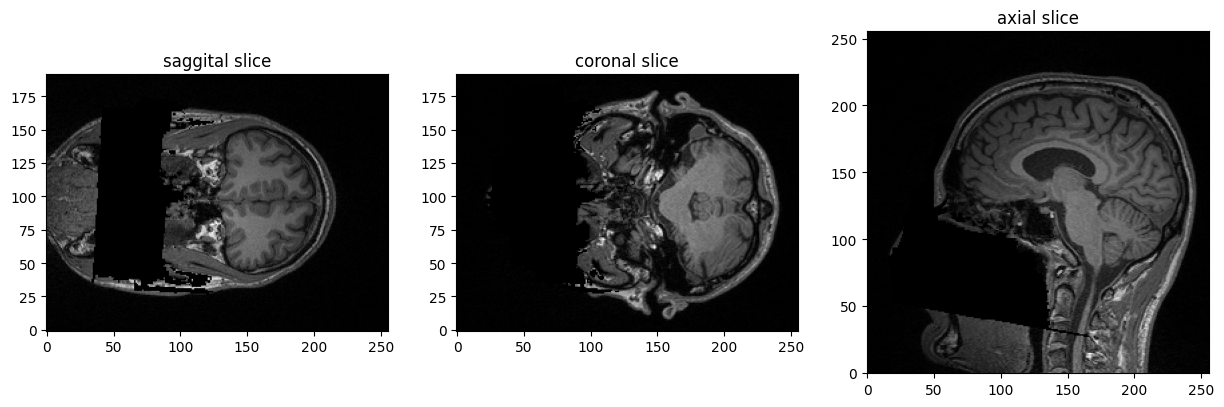

In [8]:
slices = {
  'saggital slice': anat_data[100, :, :], 
  'coronal slice': anat_data[:, 100, :], 
  'axial slice': anat_data[:, :, 100]}

fig, axes = plt.subplots(1, len(slices), figsize=(15,15))

for i, slice in enumerate(slices.values()):
    axes[i].imshow(slice.T, cmap="gray", origin="lower")
    axes[i].set_title(list(slices.keys())[i])

(Note these images have been "de-faced", hence the black wedge of missing data.)

### Affine

The final important piece of metadata associated with an image file is the **affine matrix**, a 4x4 matrix which defines how the voxel grid of the image is positioned, oriented, and scaled relative to the scanner or reference space. Without the affine matrix, the voxel coordinates are just abstract numbers. With it, you know how the image data aligns with the real world, enabling comparisons and transformations between different images or scans.

For example, if we have the voxel coordinate (26, 30, 16), without additional information, we wouldn’t know if this position is on the left or right side of the brain, or if it came from the left or right of the scanner. This is because the scanner can collect voxel data in almost any arbitrary position and orientation within the magnet.

For example, BOLD images are typically acquired at a different angle and with smaller coverage than T1-weighted anatomical images, resulting in different bounding boxes. 

<img align="centre" src="https://nipy.org/nibabel/_images/localizer.png" width="50%">

Additionally, the center of the image data is often not located at the exact center of the magnet bore (the magnet’s *isocenter*).

In our case, we have both an anatomical and a BOLD scan. Later, we will want to relate the data from the subject's *_bold.nii.gz* file to the same subject’s *_T1w.nii.gz file*. However, this is not straightforward, as the anatomical image and BOLD image were acquired with different orientations and fields of view, meaning the voxel coordinates in the BOLD image refer to different locations in the magnet compared to the anatomical image.

The affine matrix solves this as it keeps track of the relationship between voxel coordinates and a reference space (e.g., the magnet space). Knowing this relationship for both images allows us to align the voxel coordinates of the BOLD image to the spatially equivalent coordinates in the natomical image.

The origin of the scanner's reference system is at the magnet isocenter, at coordinate (0, 0, 0). The scanner’s axes, measured in mm, pass through this point. If the subject is lying face up, head first in the scanner, the axes are aligned with the subject’s head:

* The scanner's left/right axis corresponds to the subject's left-**right** axis (x). 
* The scanner's floor/ceiling axis corresponds to subject's posterior-**anterior** axis (y).
* The scanner's bore axid corresponds to the subject's inferior-**superior** axis (z).

<img align="left" src="https://people.cas.sc.edu/rorden/anatomy/tspace.gif" width="30%">

<img align="right" src="https://www.slicer.org/w/img_auth.php/2/22/Coordinate_sytems.png" width="70%">

Below is the affine matrix for our anatomical data. This matrix relates the **voxel coordinates** to the **world (scanner) coordinates**.

In [10]:
anat_affine = anat_image.affine
print(anat_affine)

[[  -0.032    0.083    0.996 -100.089]
 [  -0.999   -0.016   -0.031  164.751]
 [  -0.013    0.996   -0.084 -120.988]
 [   0.       0.       0.       1.   ]]


In the image header, the different `sform_code` and `qform_code` values specify which space the sform affine refers to, with these interpretations:

| Code | Label     | Meaning                       |
|------|-----------|--------------------------------|
| 0    | unknown   | sform not defined              |
| 1    | scanner   | scanner coordinates    |
| 2    | aligned   | aligned to some other scan|
| 3    | talairach | Talairach atlas space  |
| 4    | mni       | MNI atlas space        |


Let’s measure how 'shifted' the center of the anatomical image's voxel space is from the reference space (scanner bore) center. To do this, we can extract the affine matrix from the anatomical image and calculate the physical coordinates of the center voxel, comparing them with the origin of the scanner's reference space (0, 0, 0).

In [12]:
# Get the shape of the image data (dimensions of the voxel grid)
data_shape = anat_image.shape

# Calculate the voxel space center (the middle voxel in each dimension)
voxel_center = numpy.array(data_shape) / 2

# Convert voxel center to reference (scanner) space using the affine matrix (appending 1 for fourth element)
center_in_scanner_space = anat_affine.dot(numpy.append(voxel_center, 1))[:3]  # Applying affine transformation (removing fourth element again)

# The scanner bore center is at (0, 0, 0)
scanner_bore_center = numpy.array([0, 0, 0])

# Calculate the shift (distance between voxel space center and scanner bore center)
shift = center_in_scanner_space - scanner_bore_center

print(f"Shift of the anatomical image's voxel center from the scanner bore center: {shift} mm")

Shift of the anatomical image's voxel center from the scanner bore center: [ 2.086 31.816 -3.207] mm


NiBabel also provides a built-in function, `apply_affine`, which allows us to apply the affine transformation in a more straightforward way

In [13]:
from nibabel.affines import apply_affine 

shift = apply_affine(anat_image.affine, voxel_center)

print(f"Shift of the anatomical image's voxel center from the scanner bore center: {shift} mm")

Shift of the anatomical image's voxel center from the scanner bore center: [ 2.086 31.816 -3.207] mm


This means that the center of the anatomical image's field of view is **2.1 mm to the right** of the magnet's isocenter, **31.8 mm anterior**, and **3.2mm below** (inferior) the isocenter.

The parameters in the affine matrix allow us to determine the position of any voxel coordinate relative to the scanner's reference space.

When we register an image to a template, such as the **MNI template**, we obtain an affine matrix that defines the relationship between the voxel coordinates of the aligned image and the MNI space. In MNI space, the origin (0, 0, 0) is located at the **anterior commissure**.

When working with MNI-aligned images, it is often necessary to translate between voxel coordinates and MNI space coordinates. For example, we may need to retrieve the value of a voxel at a specific set of MNI coordinates. 

To **convert voxel coordinates into MNI space coordinates**, you can apply the affine matrix of the registered image:

```python
# Specify voxel coordinates to translate (e.g., voxel at (30, 40, 50))
voxel_coords = numpy.array([30, 40, 50])

# Convert voxel coordinates to MNI space using the affine matrix
mni_coords = apply_affine(image_affine, voxel_coords)
```

To **translate MNI space coordinates back to voxel coordinates**, you need to apply the inverse of the affine matrix:

```python
# Specify MNI coordinates (e.g., MNI coordinates at [10, 20, -15])
mni_coords = numpy.array([10, 20, -15])

# Calculate the inverse of the affine matrix
affine_inv = numpy.linalg.inv(image_affine)

# Convert MNI coordinates to voxel coordinates using the inverse affine
voxel_coords = apply_affine(affine_inv, mni_coords)
```


## Image manipulation with NiLearn

### The mean image

If you're using NiBabel to compute the mean image, you first need to load the image, extract the data, and then compute the mean manually.

However, with Nilearn, you can achieve the same result in a single line using the `mean_img` function.

In [14]:
import nilearn.image 
bold_mean_image = nilearn.image.mean_img(bold_image)

In [15]:
bold_mean_data = bold_mean_image.get_fdata()
bold_mean_data.shape

(64, 64, 33)

Nilearn also offers interactive visualisation option.

/home/rh01/miniconda3/envs/mri/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



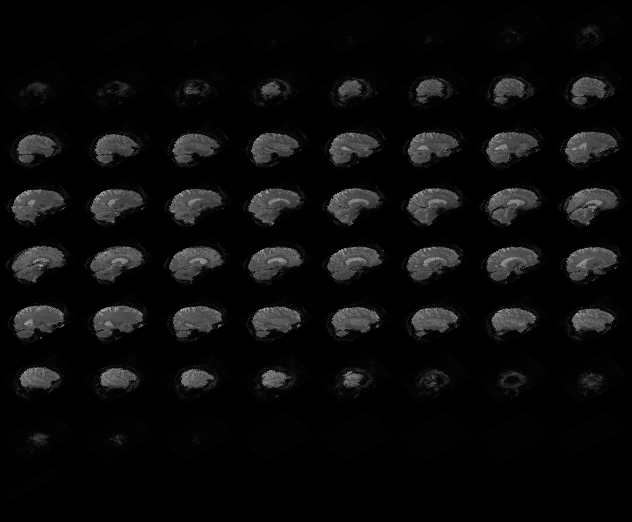
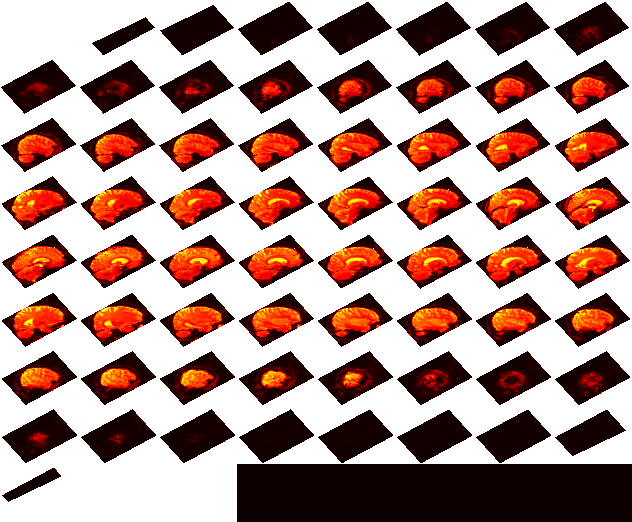

In [16]:
import nilearn.plotting

nilearn.plotting.view_img(bold_mean_image, bg_img = bold_mean_image)

### Resample image to a template

Using the `resample_to_img` function from Nilearn, we can resample one image to match the dimensions of another. For example, let’s resample an anatomical T1 image to match the dimensions of the mean image we computed earlier.

In [21]:
# image shapes before resampling
print([bold_mean_image.shape, anat_image.shape])

[(64, 64, 33), (256, 256, 192)]


In [17]:
resampled_anat = nilearn.image.resample_to_img(anat_image, bold_mean_image)

# T1 image shape after resampling
resampled_anat.shape

(64, 64, 33)

How does the resampled anatomical image look? To visualize it, we will use Nilearn’s `plot_anat` function, which allows us to plot a static image of the resampled anatomical image.

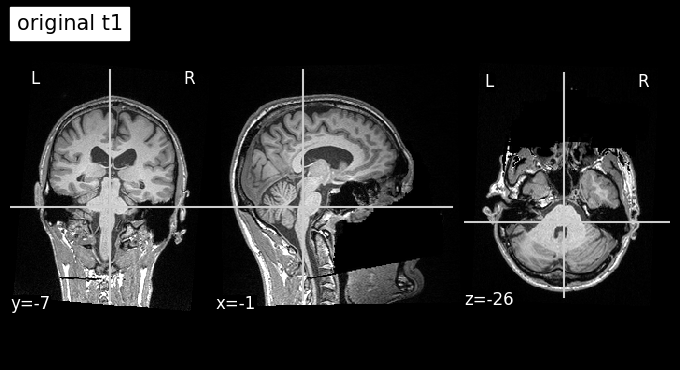

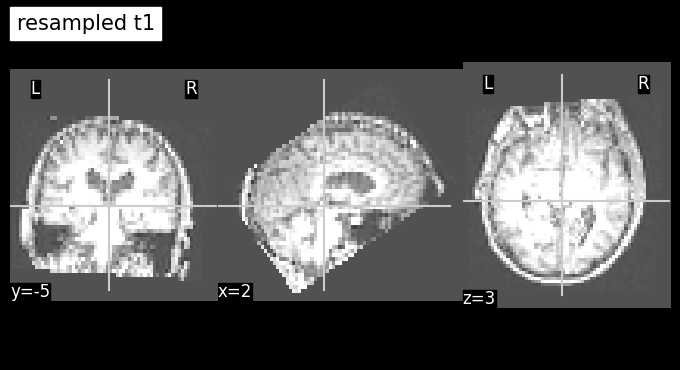

In [18]:
nilearn.plotting.plot_anat(anat_image, title = 'original t1', dim=-1);
nilearn.plotting.plot_anat(resampled_anat, title = 'resampled t1', dim=-1);

### Smooth an image

Using the `smooth_img` function from Nilearn, we can easily apply smoothing to any type of MRI image. For example, let’s take the mean image from above and apply smoothing with different full width at half maximum (FWHM) values to see how smoothing affects the image.

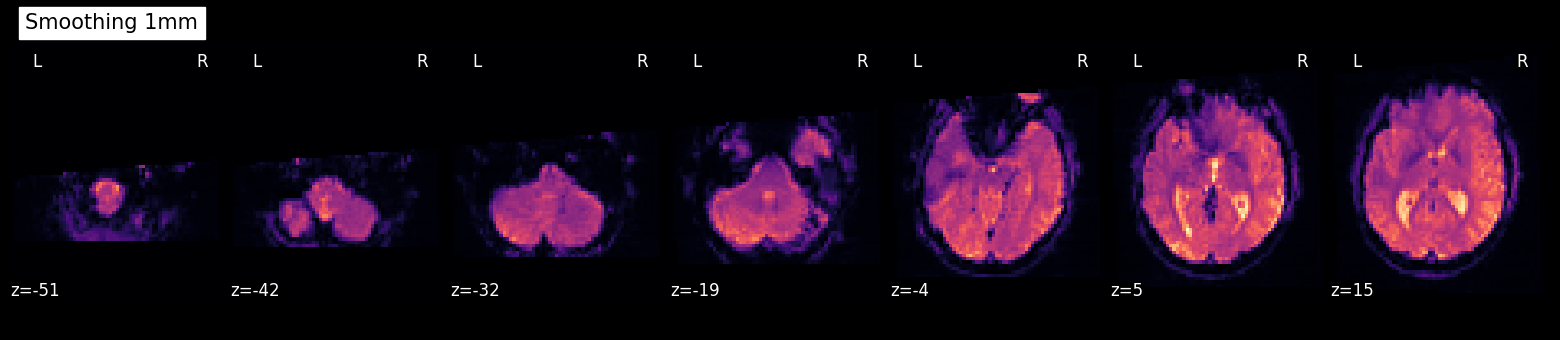

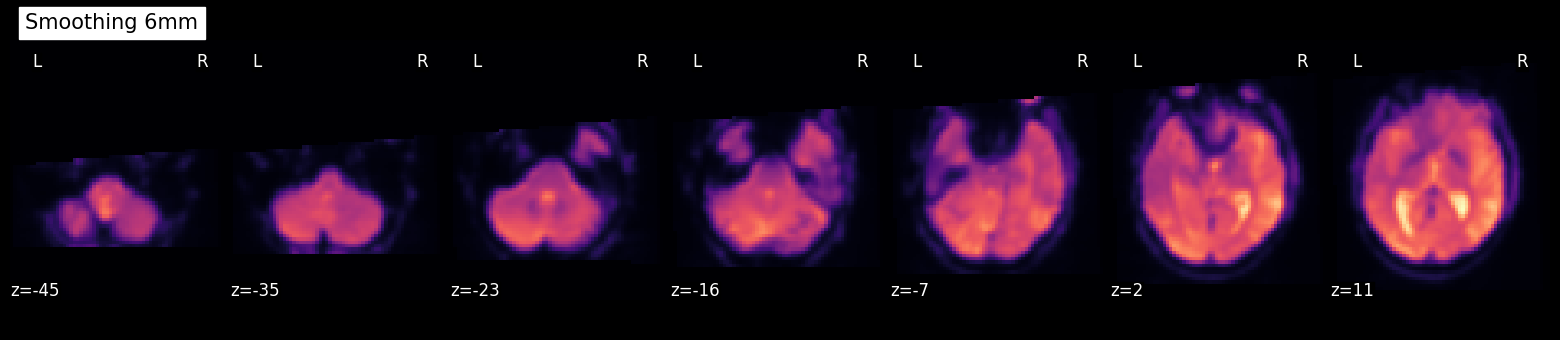

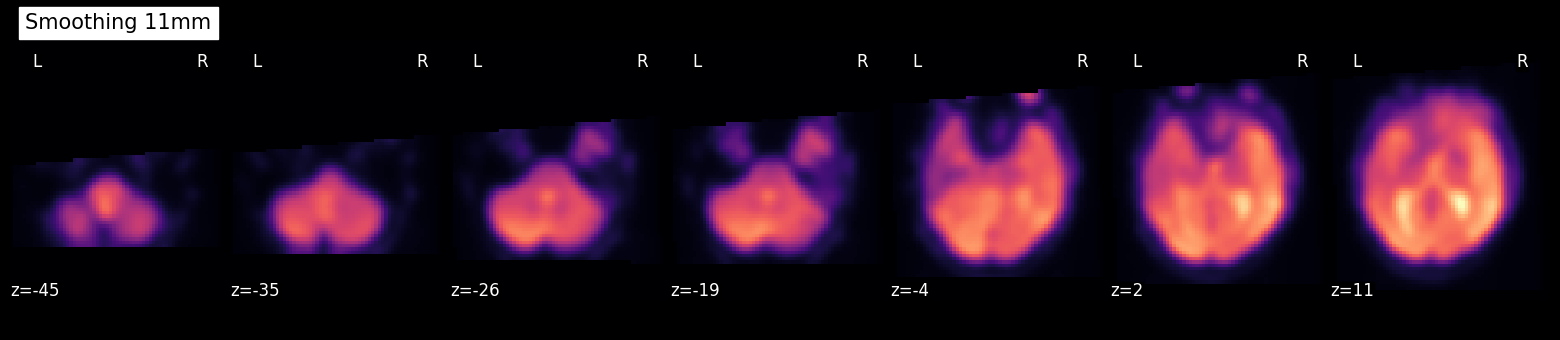

In [19]:
for fwhm in range(1, 12, 5):
    smoothed_img = nilearn.image.smooth_img(bold_mean_image, fwhm)
    nilearn.plotting.plot_epi(smoothed_img, title = "Smoothing %imm" % fwhm, display_mode = 'z', cmap = 'magma');

### Plotting a time course

Let's plot a time course of the central voxel in our BOLD imgage and some other random voxel.  

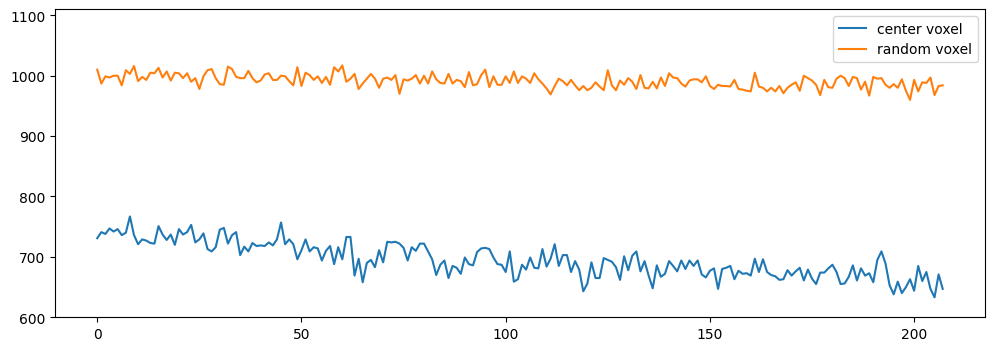

In [20]:
# get the xyz of the center 
bold_vox_center = numpy.array(bold_data.shape) / 2
x, y, z, _ = bold_vox_center

# set the plot size
plt.figure(figsize=(12, 4))

# plot the central voxel time course
plt.plot(bold_data[int(x), int(y), int(z), :])

# plot some random voxel time course
plt.plot(bold_data[28, 45, 15, :])

# add legends to the plot
plt.legend(['center voxel', 'random voxel']);
plt.gca().set_ylim([600, 1110]); # to match next plot

Alternatively, we can use Nilearn's `NiftiSpheresMasker` function, which allows us to extract time series from a single voxel or a sphere around it. The input coordinates, in this case, must be in **world coordinates**.

In [21]:
# Translate the two previously used voxel coordinates to the world coordinates
bold_center_coords = apply_affine(bold_image.affine, [x, y, z])
print(f"The center of the BOLD image in the world coordinates is {bold_center_coords}")

random_voxel_coords = apply_affine(bold_image.affine, [28, 45, 15])
print(f"The random voxel of the BOLD image in the world coordinates is {random_voxel_coords}")

The center of the BOLD image in the world coordinates is [ 4.038  8.792 24.747]
The random voxel of the BOLD image in the world coordinates is [15.824 44.446 41.75 ]


In [22]:
# Extract the time series of the center and random voxel using NiftiSpheresMasker
from nilearn.maskers import NiftiSpheresMasker

coord_masker = NiftiSpheresMasker(
    [bold_center_coords, random_voxel_coords], radius = 10 # 10mm radius
)
coord_time_series = coord_masker.fit_transform(bold_image)

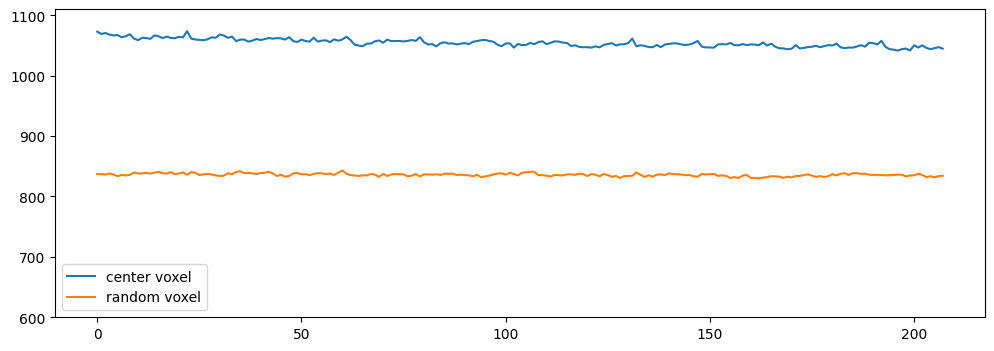

In [23]:
plt.figure(figsize=(12, 4)); plt.plot(coord_time_series);
plt.legend(['center voxel', 'random voxel']);
plt.gca().set_ylim([600, 1110]); # to match previous plot

Note that the plots are different (much smoother) compared to previously because the timeseries are now the average over many voxels within 10mm of the coordinates.

### Thresholding an image

Let's take our BOLD functional image, compute its mean image, and apply a threshold to keep only the voxels with values higher than 95% of all voxels.

/home/rh01/miniconda3/envs/mri/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



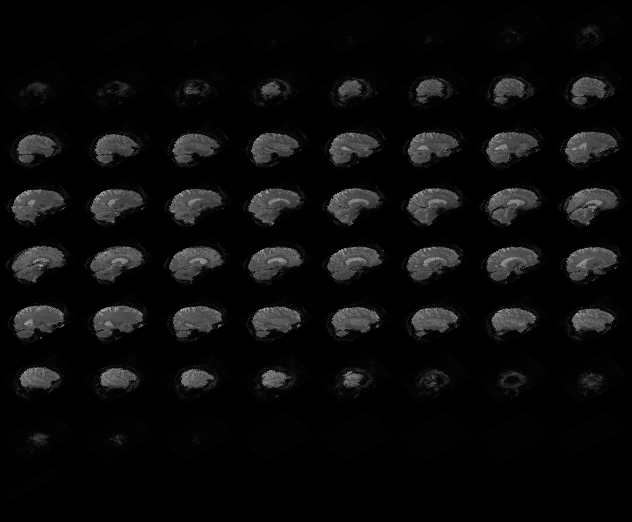
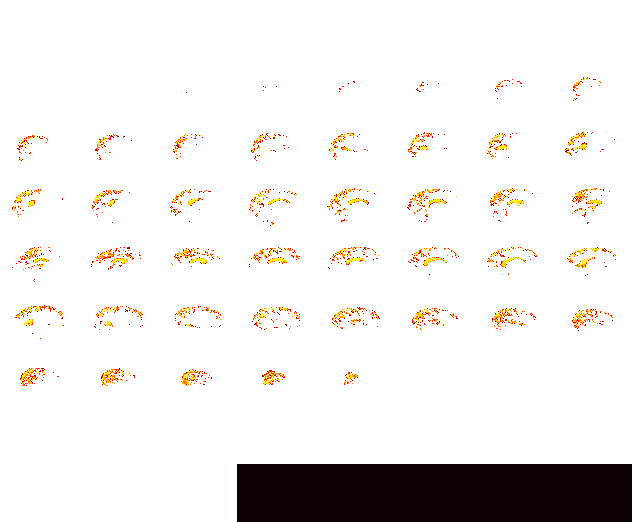

In [24]:
# create the mean image
bold_mean_image = nilearn.image.mean_img(bold_image)

# keep voxels that have a value that is higher than 95% of all voxels
thr = nilearn.image.threshold_img(bold_mean_image, threshold='95%')

# let's see how the thresholded image look compared to the original mean image
nilearn.plotting.view_img(thr, bg_img = bold_mean_image)